# Attendance analysis

In [1]:
#load modules
import pandas as pd
import numpy as np
import os

In [2]:
#set up R environment and library
%load_ext rpy2.ipython

In [3]:
%R library(ggplot2)

R[write to console]: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang



array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U9')

In [23]:
%R library(scales)

array(['scales', 'ggplot2', 'tools', 'stats', 'graphics', 'grDevices',
       'utils', 'datasets', 'methods', 'base'], dtype='<U9')

In [4]:
#function to make df readable into R
def sametype(df):
    cols = df.columns
    for index, val in enumerate(cols):
        if df[val].dtype == 'O':
            df[val] = df[val].astype('str')
    return df

## Data

### Load Data

In [5]:
#read DATA in
#first read in attendance data
attendance_df = pd.read_csv('../data/historical/HomeGames.csv')
#read in franchises for active or not
franchises_df = pd.read_csv('../data/historical/TeamsFranchises.csv')
#park info
parks_df = pd.read_csv('../data/historical/Parks.csv')
#team info
teams_df = pd.read_csv('../data/historical/Teams.csv')
#postseason stats
post_season_df = pd.read_csv('../data/historical/SeriesPost.csv')
#mycsv
stadium_historic = pd.read_csv('../data/stadiums/past_present_stadiums.csv', parse_dates=['year_opened'])

### Clean Data

In [6]:
#active franchises
active_franchises_df = franchises_df.loc[franchises_df.active == 'Y']

#only after 1968 for 50 years of data
active_teams_df = teams_df.loc[(teams_df.franchID.isin(active_franchises_df.franchID)) & (teams_df.yearID > 1968)]
active_teams_df = active_teams_df[['yearID', 'lgID', 'teamID', 'franchID', 'Rank', 'W', 'name', 'park', 'attendance']]

#need to see if made playoffs and worldseries that year
with_series = pd.merge(active_teams_df, post_season_df[['yearID', 'round', 'teamIDwinner']], how = 'left', right_on = ['yearID', 'teamIDwinner'], left_on = ['yearID', 'teamID'])
with_series = pd.merge(with_series, post_season_df[['yearID', 'round', 'teamIDloser']], how = 'left', right_on = ['yearID', 'teamIDloser'], left_on = ['yearID', 'teamID'])
with_series.rename(columns={'round_x':'round won', 'round_y':'round lost'}, inplace=True)
with_series = with_series.drop(['teamIDwinner', 'teamIDloser'], axis=1)

#with_series
with_series = sametype(with_series)
with_series.loc[(with_series['round won']=='nan') & (with_series['round lost']=='nan'), 'playoff_boolean'] = 'no'
with_series.loc[(with_series.playoff_boolean.isna()), 'playoff_boolean'] = 'yes'

#average the wins and attendance in a dataframe
mean_win_attend = active_teams_df.loc[active_teams_df.yearID > 1969][['franchID', 'W', 'attendance']].groupby(['franchID']).mean().reset_index()

#trim analysis down to teams that did better than league average
pert_teams = mean_win_attend.loc[mean_win_attend.W > mean_win_attend['W'].mean()]['franchID'].reset_index()
#take arizona out since formed 1998
pert_teams = pert_teams.loc[pert_teams.franchID != "ARI"]['franchID']
pert_active_team_df = active_teams_df.loc[active_teams_df.franchID.isin(pert_teams)]
pert_series = with_series.loc[with_series.franchID.isin(pert_teams)]

#start creating final table with 11 teams and playoff or not each year
t2 = pd.merge(pert_active_team_df, pert_series[['yearID', 'lgID', 'teamID', 'franchID', 'playoff_boolean']], how = 'left')

#add in stadium info
stadium_historic['year_opened'] = stadium_historic.year_opened.dt.year
pert_df = pd.merge(t2,stadium_historic, how ='left', right_on = ['franchID', 'Stadium_name'],left_on = ['franchID', 'park'])
pert_df = pert_df.drop(['Stadium_name'], axis=1)
pert_df['prev_playoff'] = pert_df.sort_values(['franchID', 'yearID']).shift(1)['playoff_boolean']
#start from 1970 becuase of shift function earlier
pert_df = pert_df.loc[pert_df.yearID > 1969]
pert_df = pert_df.drop_duplicates()
#percent stadium is filled
pert_df['percent_filled'] = (pert_df.attendance/81)/pert_df.capacity
#add in column for new stadium
pert_df.loc[pert_df.yearID == pert_df.year_opened, 'new_stadium'] = 'yes'
pert_df.loc[(pert_df.new_stadium.isna()), 'new_stadium'] = 'no'

#for vertical line
new_stadium = pert_df.loc[pert_df.new_stadium == 'yes']

### Data exploration

In [7]:
pert_df.loc[pert_df.playoff_boolean == 'no'].percent_filled.mean()

0.5304146451526583

In [8]:
pert_df.loc[pert_df.playoff_boolean == 'yes'].percent_filled.mean()

0.7005870103818628

In [9]:
(0.7005870103818628 - 0.5304146451526583)/(0.5304146451526583)*100

32.08289340884002

### Data Visulization

In [10]:
%R -i pert_df

In [11]:
%R -i new_stadium

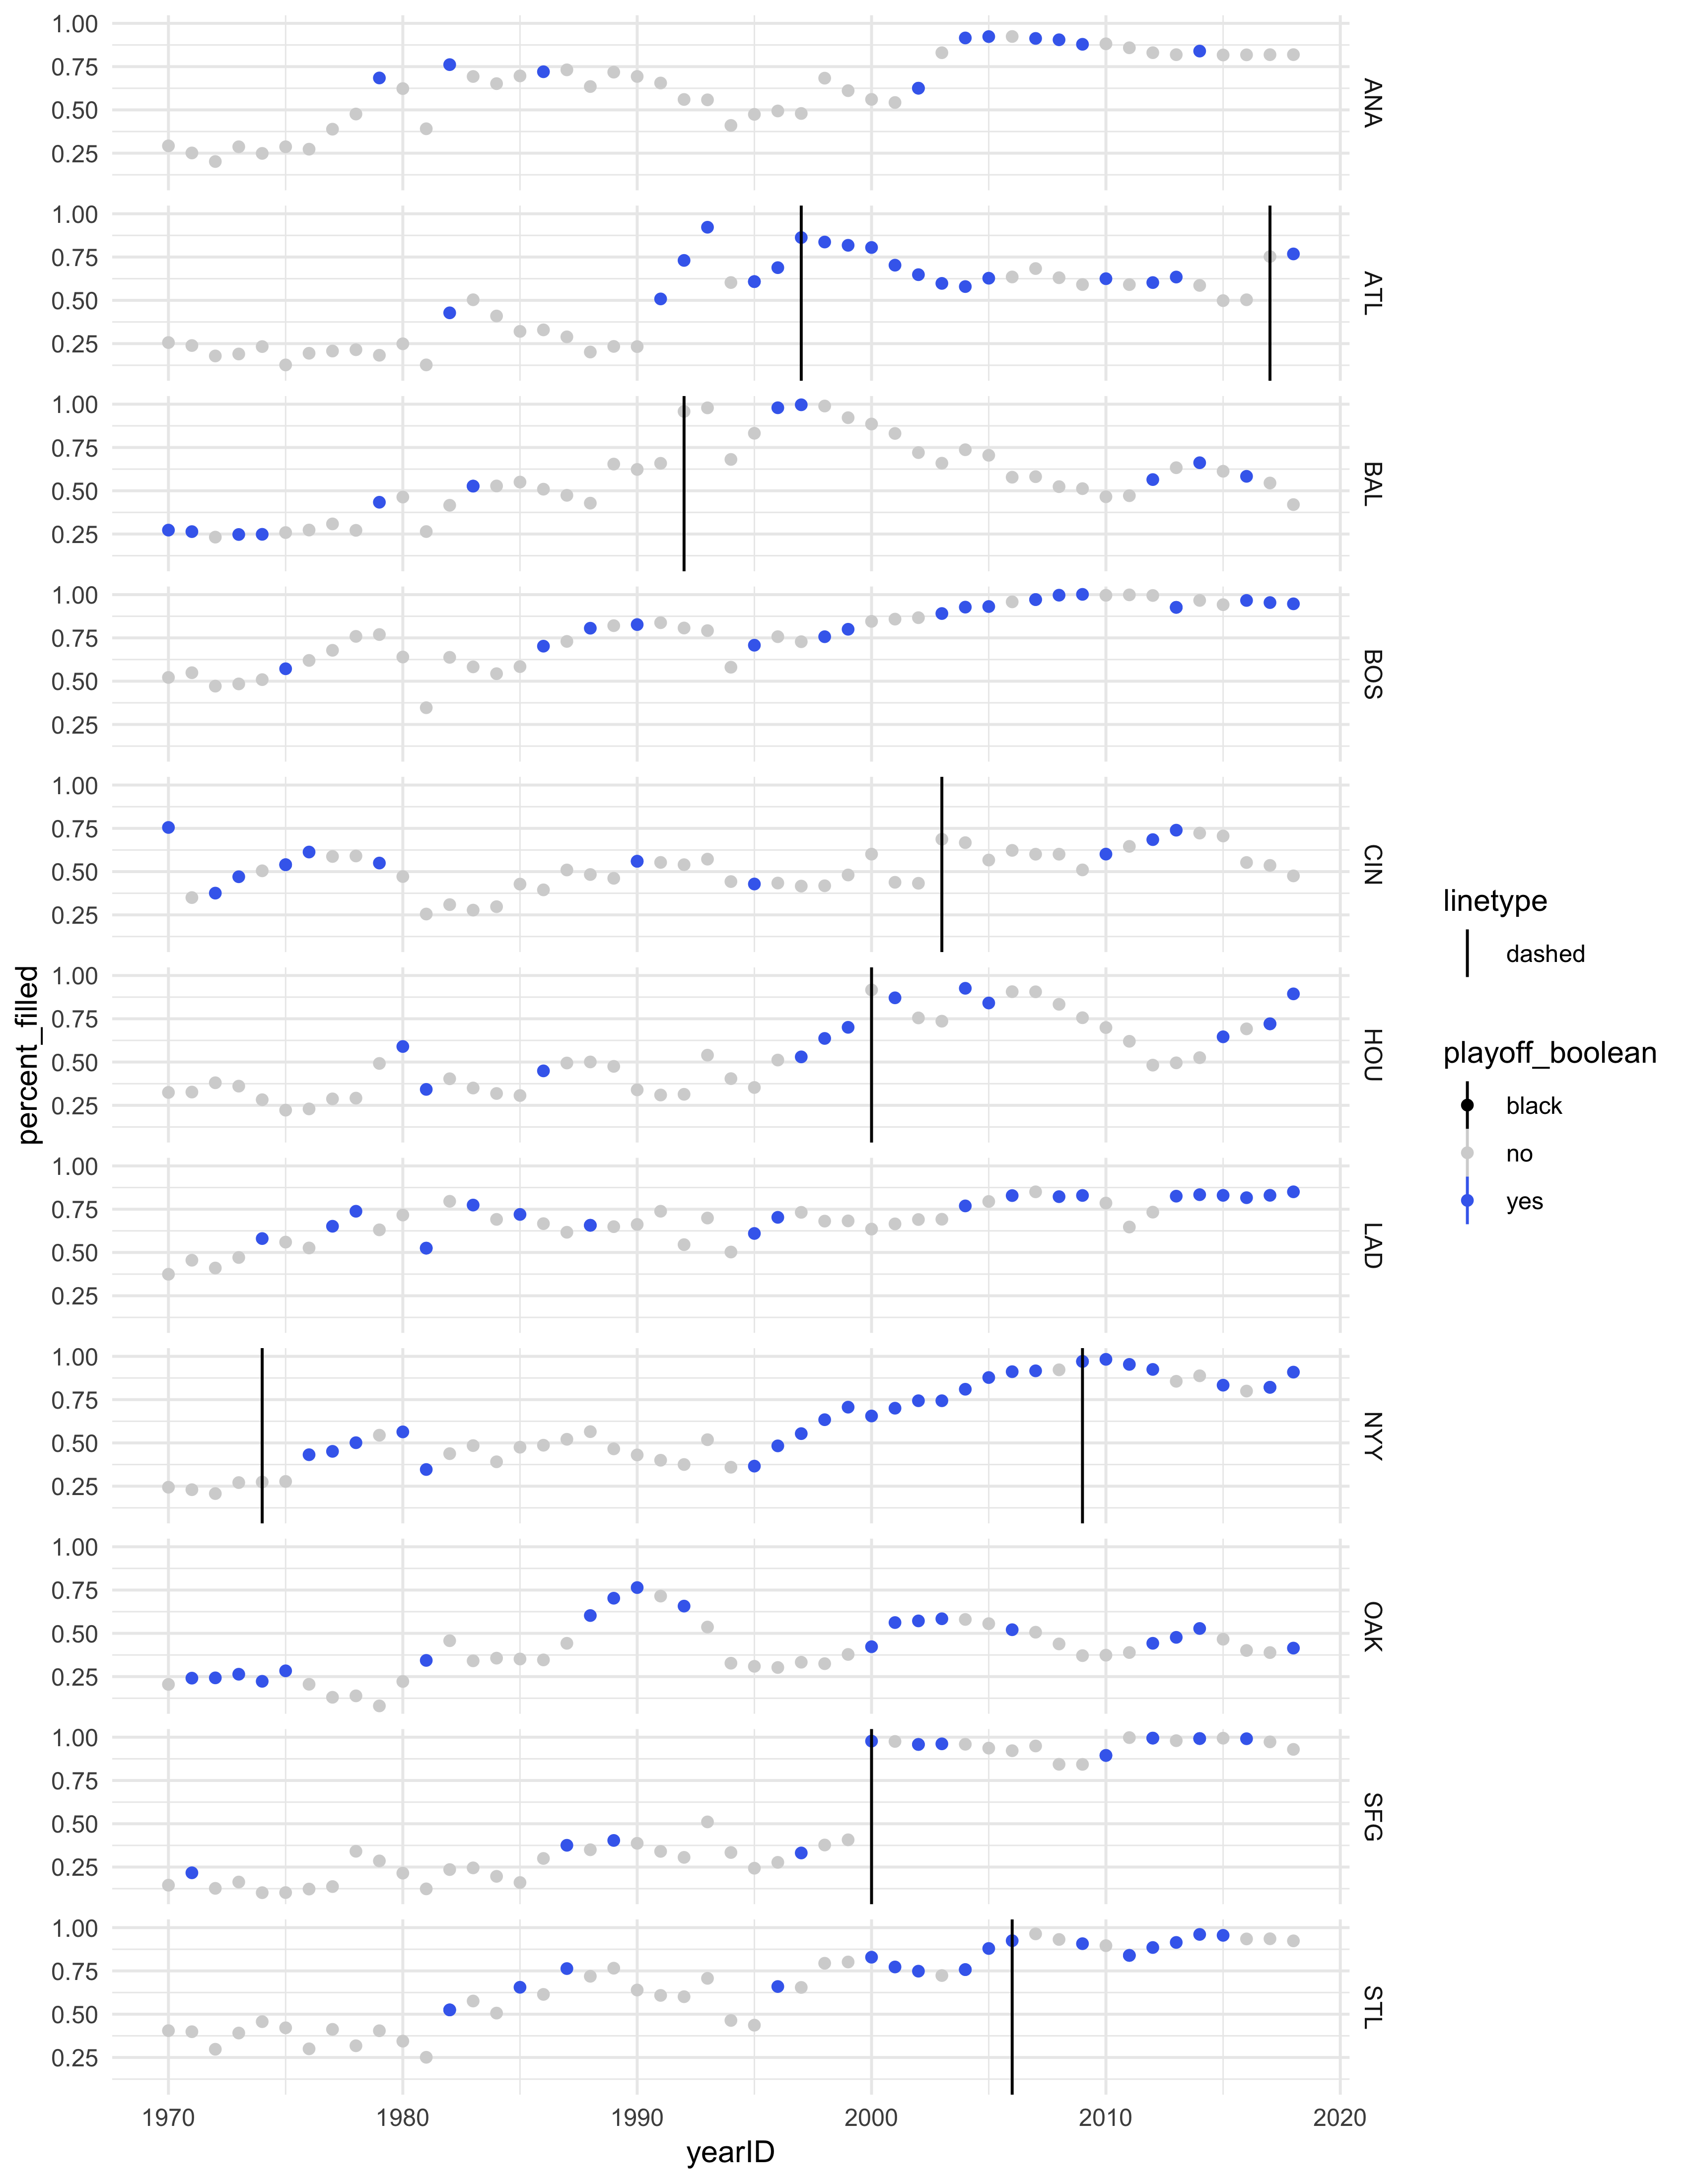

In [16]:
%%R -w 8.5 -h 11 --units in -r 400

ggplot(pert_df, aes(x=yearID,y=percent_filled, group = 1)) + 
    geom_point(aes(colour = playoff_boolean), size = 1.5) + 
    geom_vline(data = new_stadium, aes(xintercept = yearID, linetype = 'dashed', colour = 'black')) + 
    facet_grid(rows = vars(franchID)) + 
    theme_minimal() +
    scale_colour_manual(values = c("black", "grey83", "royalblue2"))
    
#ggsave('../images/attend_percentage.pdf')

In [17]:
yanks_df = pert_df.loc[pert_df.franchID == 'NYY']

In [21]:
%R -i yanks_df
#only do yanks playoffs
#make labels into 

In [36]:
%%R -w 8.5 -h 5 --units in -r 400

ggplot(yanks_df, aes(x=yearID,y=percent_filled, group = 1)) + 
    geom_point(aes(colour = playoff_boolean), size = 1.5) + 
    theme_minimal() +
    scale_colour_manual(values = c("grey83", "royalblue2")) +
    scale_y_continuous(labels = scales::percent) +
    ylab("Percent of Stadium Filled Over the Season\n") +
    xlab("MLB season") + ggtitle('Yanks Playoff Over the Years')
ggsave('../images/yanks_playoff.png')

R[write to console]: Saving 8.5 x 5 in image



In [38]:
astro_df = pert_df.loc[pert_df.franchID == 'HOU']

In [39]:
%R -i astro_df
#only do houston playoffs

In [52]:
%%R -w 8.5 -h 5 --units in -r 400

ggplot(astro_df, aes(x=yearID,y=percent_filled, group = 1)) + 
    geom_point(aes(colour = playoff_boolean), size = 1.5) + 
    theme_minimal() +
    scale_colour_manual(values = c("grey83", "royalblue2")) +
    scale_y_continuous(labels = scales::percent) +
    ylab("Percent of Stadium Filled Over the Season\n") +
    xlab("MLB season") + ggtitle('Stros Playoff Over the Years')
#ggsave('../images/astros_playoff.png')

R[write to console]: Saving 8.5 x 5 in image



In [46]:
#houston playoff and stadium
astro_new_stad = new_stadium.loc[new_stadium.franchID == 'HOU']

In [47]:
%R -i astro_new_stad

In [65]:
%%R -w 8.5 -h 5 --units in -r 400

ggplot(astro_df, aes(x=yearID,y=percent_filled, group = 1)) + 
    geom_point(aes(colour = playoff_boolean), size = 1.5) + 
    theme_minimal() +
    scale_colour_manual(values = c("red", "grey83", "royalblue2")) +
    scale_y_continuous(labels = scales::percent) +
    ylab("Percent of Stadium Filled Over the Season\n") +
    xlab("MLB season") + ggtitle('Stros Playoff Over the Years') +
    geom_vline(data = astro_new_stad, aes(xintercept = yearID, linetype = 'dashed', colour = 'black')) +
    annotate("text", x = 2003.4, y = .23, label = "New Stadium", size = 3.1, colour = "red4", fontface = 'bold')

ggsave('../images/astros_playoff_newstad.png')

R[write to console]: Saving 8.5 x 5 in image

